In [52]:
import pickle
import pycaret
import pandas as pd
import seaborn as sns
from pycaret.classification import *
from dataprep.eda import create_report
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters

In [53]:
cmap='seismic'
sns.set_palette(sns.color_palette(cmap))

In [54]:
metric = 'AUC' # F1 or AUC

-----------------------------
# Functions

In [55]:
def train_test_split_per_user(data, train_size=0.7):
    users = list(set(data.id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice = int(train_size * total_users)
    users_train = users[:slice]
    users_test = users[slice:]
    return data[data.id.isin(users_train)], data[data.id.isin(users_test)]

# Label Engineering VO2Max Get VO2 max (cardio score) category based on age category and filteredDemographicVO2Max,
# according to this publication: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073182 as
# summarized here: https://www.healthline.com/health/vo2-max#increasing-vo%E2%82%82-max

def get_cardio_category(gender, age, vo2max):
    if pd.isna(gender):
        return np.nan
    if gender == "MALE":
        if age == "<30":
            if vo2max >= 51.1:
                return "Superior/Excellent"
            elif vo2max >= 41.7:
                return "Fair/Good"
            else:
                return "Poor"
        else:
            if vo2max >= 48.3:
                return "Superior/Excellent"
            elif vo2max >= 40.5:
                return "Fair/Good"
            else:
                return "Poor"
    else:
        if age == "<30":
            if vo2max >= 43.9:
                return "Superior/Excellent"
            elif vo2max >= 36.1:
                return "Fair/Good"
            else:
                return "Poor"
        else:
            if vo2max >= 42.4:
                return "Superior/Excellent"
            elif vo2max >= 34.4:
                return "Fair/Good"
            else:
                return "Poor"


-----------
# Reading the data

In [56]:
df=pd.read_pickle('../data/unified_dataframe/dataframe_demographics_unpreprocessed.pkl')
df = df[df['filteredDemographicVO2Max'].notna()]
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,Martial Arts,Run,Spinning,Sport,Swim,Treadmill,Walk,Weights,Workout,Yoga/Pilates
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,621e328667b776a240281372,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,621e326767b776a24012e179,2021-05-24,NaN,46.120,53.968,95.3,14.4,80.0,0.666667,0.925,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,621e332267b776a24092a584,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,621e335a67b776a240bb12ff,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
#create_report(df).show_browser()

In [58]:
df_pre=pd.read_pickle('../data/unified_dataframe/dataframe_demographics_preprocessed.pkl')
df_pre = df_pre[df_pre['filteredDemographicVO2Max'].notna()]
df_pre.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,Steps_hour14,Steps_hour15,Steps_hour16,Steps_hour17,Steps_hour18,Steps_hour19,Steps_hour20,Steps_hour21,Steps_hour22,Steps_hour23
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,95.9,14.8,78.0,0.833333,0.675,...,191.0,33.0,342.0,1712.0,1838.0,160.0,155.0,37.0,31.0,53.0
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,95.9,15.8,80.0,0.833333,0.725,...,120.0,24.0,446.0,377.0,3165.0,332.0,97.0,9.0,24.0,58.0
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,95.9,14.6,84.0,0.966667,0.725,...,85.0,477.0,390.0,2821.0,293.0,158.0,66.0,0.0,70.0,74.0
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,95.9,14.8,82.0,0.933333,0.725,...,58.0,296.0,401.0,21.0,3054.0,503.0,411.0,96.0,63.0,8.0
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,95.9,15.2,81.0,0.866667,0.725,...,250.0,82.0,1363.0,3014.0,81.0,104.0,1984.0,18.0,141.0,60.0


In [59]:
#create_report(df_pre).show_browser()

-----------------
# Predicting VO2Max

In [60]:
df.columns

Index(['id', 'date', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage',
       'exertion_points_percentage', 'responsiveness_points_percentage',
       'daily_temperature_variation', 'calories', 'filteredDemographicVO2Max',
       'distance', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
       'mindfulness_session', 'scl_avg', 'resting_hr', 'sleep_duration',
       'minutesToFallAsleep', 'minutesAsleep', 'minutesAwake',
       'minutesAfterWakeup', 'sleep_efficiency', 'sleep_deep_ratio',
       'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1',
       'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age',
       'gender', 'bmi', 'heart_rate_alert', 'startTime', 'endTime',
       'month_sin', 'weekday_sin', 'week_sin', 'day_sin', 'month_cos',
      

In [61]:
df['fitness_level'] = df.apply(lambda row: get_cardio_category(row["gender"], row['age'], row["filteredDemographicVO2Max"]), axis=1)
df.fitness_level.astype(str)
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,Run,Spinning,Sport,Swim,Treadmill,Walk,Weights,Workout,Yoga/Pilates,fitness_level
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Superior/Excellent
1,621e328667b776a240281372,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Fair/Good
2,621e326767b776a24012e179,2021-05-24,NaN,46.120,53.968,95.3,14.4,80.0,0.666667,0.925,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Superior/Excellent
3,621e332267b776a24092a584,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Superior/Excellent
5,621e335a67b776a240bb12ff,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Superior/Excellent


In [62]:
df_pre['fitness_level'] = df_pre.apply(lambda row: get_cardio_category(row["gender"], row['age'], row["filteredDemographicVO2Max"]), axis=1)
df_pre.fitness_level.astype(str)
df_pre.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,Steps_hour15,Steps_hour16,Steps_hour17,Steps_hour18,Steps_hour19,Steps_hour20,Steps_hour21,Steps_hour22,Steps_hour23,fitness_level
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,95.9,14.8,78.0,0.833333,0.675,...,33.0,342.0,1712.0,1838.0,160.0,155.0,37.0,31.0,53.0,Superior/Excellent
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,95.9,15.8,80.0,0.833333,0.725,...,24.0,446.0,377.0,3165.0,332.0,97.0,9.0,24.0,58.0,Superior/Excellent
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,95.9,14.6,84.0,0.966667,0.725,...,477.0,390.0,2821.0,293.0,158.0,66.0,0.0,70.0,74.0,Superior/Excellent
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,95.9,14.8,82.0,0.933333,0.725,...,296.0,401.0,21.0,3054.0,503.0,411.0,96.0,63.0,8.0,Superior/Excellent
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,95.9,15.2,81.0,0.866667,0.725,...,82.0,1363.0,3014.0,81.0,104.0,1984.0,18.0,141.0,60.0,Superior/Excellent


In [63]:
fitness_level = df.drop(columns=['date','startTime', 'endTime','age', 'gender', 'bmi','filteredDemographicVO2Max'])

In [64]:
print(fitness_level['fitness_level'].isna().sum())
fitness_level = fitness_level[fitness_level['fitness_level'].notna()]
print(fitness_level['fitness_level'].isna().sum())

193
0


In [65]:
train_data, test_data = train_test_split_per_user(fitness_level)

fold_groups = train_data.id
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

In [66]:
s = setup(data=train_data, target='fitness_level', silent=True, session_id=123, 
          fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, test_data=test_data)

,Description,Value
0,session_id,123
1,Target,fitness_level
2,Target Type,Multiclass
3,Label Encoded,"Fair/Good: 0, Poor: 1, Superior/Excellent: 2"
4,Original Data,"(2471, 68)"
5,Missing Values,True
6,Numeric Features,39
7,Categorical Features,28
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='fitness_level',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numer...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_

**compare_models:** 
This function trains and evaluates the performance of all estimators available in the model library using cross-validation. The output of this function is a scoring grid with average cross-validated scores.

In [67]:
best = compare_models(sort = '%s'%metric) # change to F1 and AUC

create_model_container: 0
master_model_container: 0
display_container: 2
[]
compare_models() succesfully completed......................................


In [68]:
results = pull() 

In [69]:
print(df_pre.columns.tolist())

['id', 'date', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage', 'exertion_points_percentage', 'responsiveness_points_percentage', 'daily_temperature_variation', 'calories', 'filteredDemographicVO2Max', 'distance', 'bpm', 'lightly_active_minutes', 'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes', 'mindfulness_session', 'scl_avg', 'resting_hr', 'sleep_duration', 'minutesToFallAsleep', 'minutesAsleep', 'minutesAwake', 'minutesAfterWakeup', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1', 'minutes_below_default_zone_1', 'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age', 'gender', 'bmi', 'heart_rate_alert', 'month_sin', 'weekday_sin', 'week_sin', 'day_sin', 'month_cos', 'weekday_cos', 'week_cos', 'day_cos', 'DAILY_FLOORS', 'DAILY_STEPS', 'GOAL_BASED_WEIGHT_LOSS', 'LIFETIME_DISTANCE', 'LIFETIME_F

In [70]:
fitness_level = df_pre.drop(columns=['date',  'age', 'gender','bmi', 'filteredDemographicVO2Max'])

In [71]:
print(fitness_level['fitness_level'].isna().sum())
fitness_level = fitness_level[fitness_level['fitness_level'].notna()]
print(fitness_level['fitness_level'].isna().sum())

193
0


In [72]:
train_data, test_data = train_test_split_per_user(fitness_level)

fold_groups = train_data.id
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

https://pycaret.gitbook.io/docs/get-started/preprocessing/scale-and-transform#effect-of-feature-transformation

In [73]:
s = setup(data=train_data, target='fitness_level', silent=True, session_id=123, 
          fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, test_data=test_data, 
          normalize=True, normalize_method='minmax', fix_imbalance=True, remove_multicollinearity = True,
          multicollinearity_threshold = 0.6)

,Description,Value
0,session_id,123
1,Target,fitness_level
2,Target Type,Multiclass
3,Label Encoded,"Fair/Good: 0, Poor: 1, Superior/Excellent: 2"
4,Original Data,"(2471, 145)"
5,Missing Values,True
6,Numeric Features,107
7,Categorical Features,37
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='fitness_level',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numer...
                ('dummy', Dummify(target='fitness_level')),
                ('fix_perfect', Remove_100(target='fitness_level')),
                ('clean_names', Clean_Colum_Nam

In [74]:
best = compare_models(sort = '%s'%metric) # change to F1 and AUC

create_model_container: 0
master_model_container: 0
display_container: 2
[]
compare_models() succesfully completed......................................


In [75]:
plot_model(best, plot = 'auc')

Initializing plot_model()
plot_model(fold=None, use_train_data=False, verbose=True, is_in_evaluate=False, display=None, display_format=None, estimator=[], feature_name=None, fit_kwargs=None, groups=None, label=False, plot=auc, plot_kwargs=None, save=False, scale=1, system=True)
Checking exceptions


ValueError: Estimator [] does not have the required fit() method.

In [76]:
df=pd.read_pickle('../data/unified_dataframe/dataframe_demographics_preprocessed.pkl')



df['fitness_level'] = df.apply(lambda row: get_cardio_category(row["gender"], row['age'], row["filteredDemographicVO2Max"]), axis=1)
df.fitness_level.astype(str)
df.head()

fitness_level = df.drop(columns=['date', 'age','gender','bmi','filteredDemographicVO2Max'])

fitness_level = fitness_level[fitness_level['fitness_level'].notna()]
y = fitness_level['fitness_level']

In [77]:
cols = ['stress_score', 'steps', 'sleep_duration']

for col in cols:
    extracted_features = extract_features(df, column_id="id", column_sort="date", 
                                          n_jobs=5, column_kind=None, column_value=col, 
                                          show_warnings=False)
    extracted_features = extracted_features.reset_index()
    extracted_features = extracted_features.rename(columns={"index": "id"})
    fitness_level = fitness_level.merge(extracted_features, how='left', on=['id'])

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.22it/s]


In [78]:
train_data, test_data = train_test_split_per_user(fitness_level)

fold_groups = train_data.id
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

In [79]:
s = setup(data=train_data, target='fitness_level', silent=True, session_id=123, 
          fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, test_data=test_data, 
          normalize=True, normalize_method='minmax', fix_imbalance=True, remove_multicollinearity = True,
          multicollinearity_threshold = 0.6)

,Description,Value
0,session_id,123
1,Target,fitness_level
2,Target Type,Multiclass
3,Label Encoded,"Fair/Good: 0, Poor: 1, Superior/Excellent: 2"
4,Original Data,"(3234, 2512)"
5,Missing Values,True
6,Numeric Features,1685
7,Categorical Features,826
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='fitness_level',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numer...
                ('dummy', Dummify(target='fitness_level')),
                ('fix_perfect', Remove_100(target='fitness_level')),
                ('clean_names', Clean_Colum_Nam

In [80]:
best = compare_models(sort = '%s'%metric) # change to F1 and AUC

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7012,0.7753,0.5744,0.5997,0.6392,0.4712,0.5088,0.4400
gbc,Gradient Boosting Classifier,0.5802,0.7581,0.5409,0.6254,0.5850,0.3168,0.3461,8.6333
lightgbm,Light Gradient Boosting Machine,0.6283,0.7326,0.5380,0.6447,0.6199,0.3586,0.3812,1.8167
rf,Random Forest Classifier,0.6782,0.7308,0.5647,0.7155,0.6351,0.4283,0.4713,0.5200
lr,Logistic Regression,0.5808,0.7021,0.5669,0.6061,0.5453,0.3121,0.3375,3.3700
lda,Linear Discriminant Analysis,0.5479,0.6971,0.5736,0.5841,0.5331,0.2807,0.3107,0.6467
nb,Naive Bayes,0.5212,0.6481,0.4931,0.6195,0.5381,0.2433,0.2621,0.7900
dt,Decision Tree Classifier,0.4953,0.6173,0.4785,0.5429,0.4744,0.2198,0.2522,0.3133
knn,K Neighbors Classifier,0.3213,0.6119,0.4529,0.6199,0.2668,0.1007,0.1533,2.5500
ada,Ada Boost Classifier,0.3870,0.5799,0.4134,0.4496,0.3517,0.1063,0.1211,1.1067


create_model_container: 14
master_model_container: 14
display_container: 2
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
compare_models() succesfully completed......................................


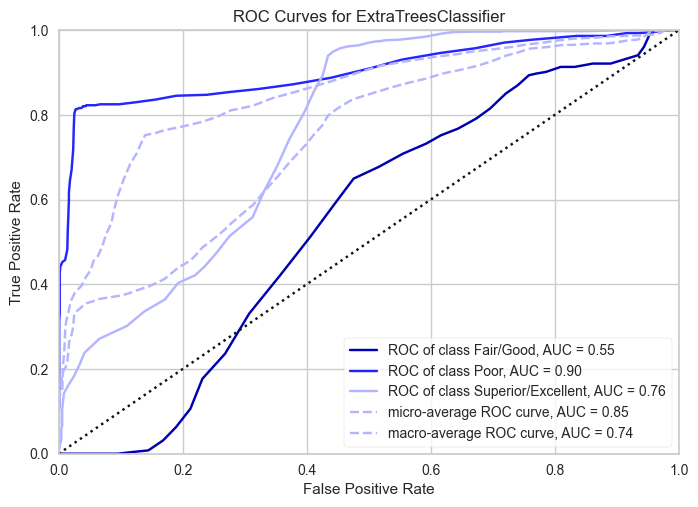

Visual Rendered Successfully
plot_model() succesfully completed......................................


In [81]:
plot_model(best, plot = 'auc')

In [82]:
d=pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(best.coef_[0])}).sort_values(by='Value', ascending=False)

Initializing get_config()
get_config(variable=X_train)
Global variable: X_train returned as       nightly_temperature    nremhr     rmssd      spo2  \
1595             0.748920  0.681253  0.316019  0.517648   
1596             0.748920  0.681253  0.316019  0.517648   
1597             0.748920  0.681253  0.316019  0.517648   
1598             0.748920  0.681253  0.316019  0.517648   
1599             0.748920  0.681253  0.316019  0.517648   
...                   ...       ...       ...       ...   
4824             0.748920  0.681253  0.316019  0.517648   
4825             0.753996  0.604888  0.283322  0.517648   
4826             0.724200  0.757760  0.178445  0.517648   
4827             0.763270  0.717682  0.210490  0.517648   
4828             0.743278  0.712988  0.210453  0.517648   

      full_sleep_breathing_rate  sleep_points_percentage  \
1595                   0.621849                 0.733333   
1596                   0.621849                 0.733333   
1597               

AttributeError: 'ExtraTreesClassifier' object has no attribute 'coef_'

In [ ]:
pd.set_option('display.max_rows', 500)
d.reset_index(inplace=True)
d

In [ ]:
d['Feature']